In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from planck_util import PlanckSpectrumT

from pspy import so_map

# Generate Two Realizations

In [56]:
nside=2048
# ncomp=1 mean that we are going to use only spin0 field (ncomp=3 for spin 0 and 2 fields
ncomp=1
# clfile are the camb lensed power spectra
clfile='../../data/bode_almost_wmap5_lmax_1e4_lensedCls_startAt2.dat'
# a binningfile with format, lmin,lmax,lmean
binning_file='../../data/binningFile_100_50.dat'
# the maximum multipole to consider
lmax=3*nside-1
rms_uKarcmin_T=20

# the templates for the CMB splits
template= so_map.healpix_template(ncomp,nside=nside)
#First let's generate a CMB realisation
cmb=template.synfast(clfile)

beam_filename = f'planck_beam/beam_likelihood_{143}hm1x{143}hm2.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) 

split=cmb.copy()
#let's add noise to it with rms 20 uk.arcmin
# noise = so_map.white_noise(split,rms_uKarcmin_T=rms_uKarcmin_T)
hp.write_map('split0raw.fits', split0/1e6, overwrite=True)
# split.data+=noise.data
split0 = hp.sphtfunc.smoothing(split.data, beam_window=beam, pol=False)
hp.write_map('split0.fits', split0/1e6, overwrite=True)

split=cmb.copy()
#let's add noise to it with rms 20 uk.arcmin
# noise = so_map.white_noise(split,rms_uKarcmin_T=rms_uKarcmin_T)
# split.data+=noise.data
hp.write_map('split1raw.fits', split1/1e6, overwrite=True)
split1 = hp.sphtfunc.smoothing(split.data, beam_window=beam, pol=False)
hp.write_map('split1.fits', split1/1e6, overwrite=True)

Using provided beam window function
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Using provided beam window function
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [107]:
# one_mask = np.ones(hp.nside2npix(nside))

# Compute Power Spectra

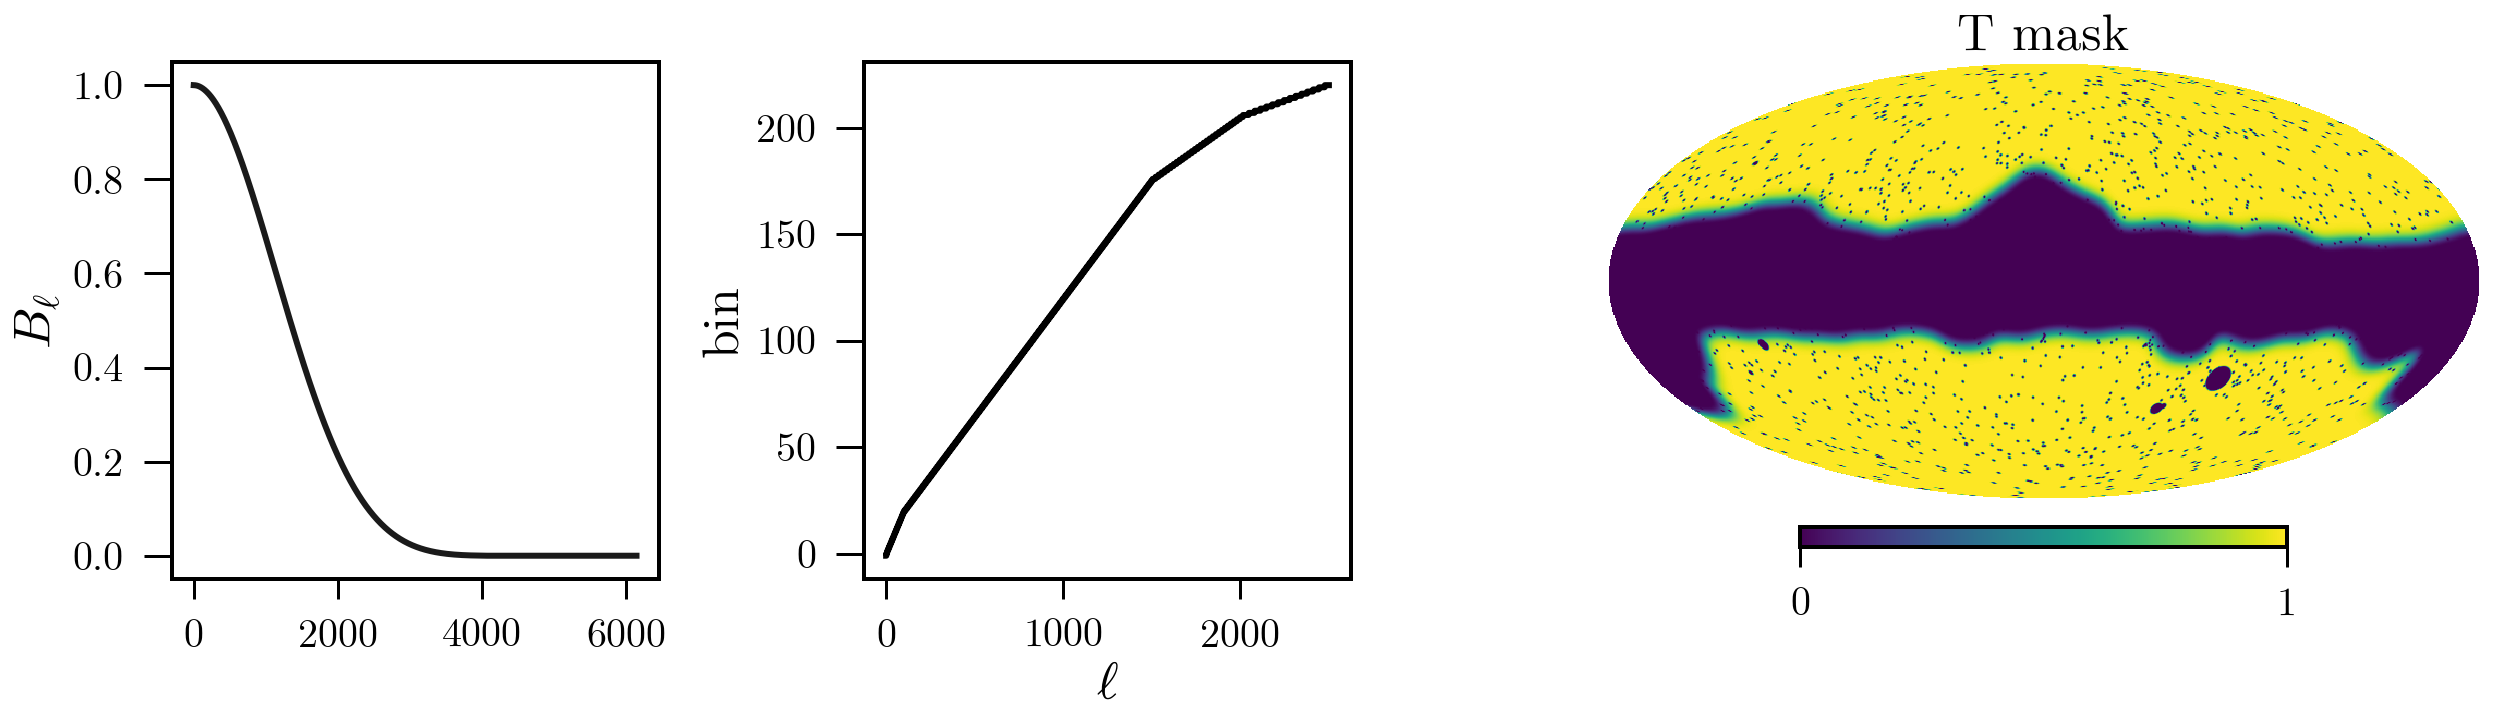

In [108]:
cl_143 = PlanckSpectrumT(debug=True, l_max=2500,
                         map0_file='split0.fits', map1_file='split1.fits')

In [109]:
ell, cl = cl_143.get_spec()

In [110]:
ell_th_temp, dl_th_temp = np.genfromtxt(clfile, usecols=(0,1), unpack=True)
dl_th = np.zeros(np.max(ell_th_temp.astype(int))+1)
dl_th[ell_th_temp.astype(int)] = dl_th_temp
dl_th = dl_th[:2000+1]

In [116]:
binleft, binright = np.genfromtxt('Planck_data/binused.dat', 
                                          unpack=True, usecols=(0,1), dtype=((int), (int)))

binleft, binright = binleft, binright
ells = np.arange(2000+1)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
    
binned_ell = np.array([ np.sum(ells[bpws==bp])/np.sum(bpws==bp)
                       for bp in range(len(binleft)) ])
cl_th = dl_th
binned_theory = np.array([ np.sum(
        cl_th[bpws==bp]) / np.sum(bpws==bp) 
                          for bp in range(len(binleft)) ])

/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in long_scalars
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


Text(0, 0.5, '$D_{\\ell}$')

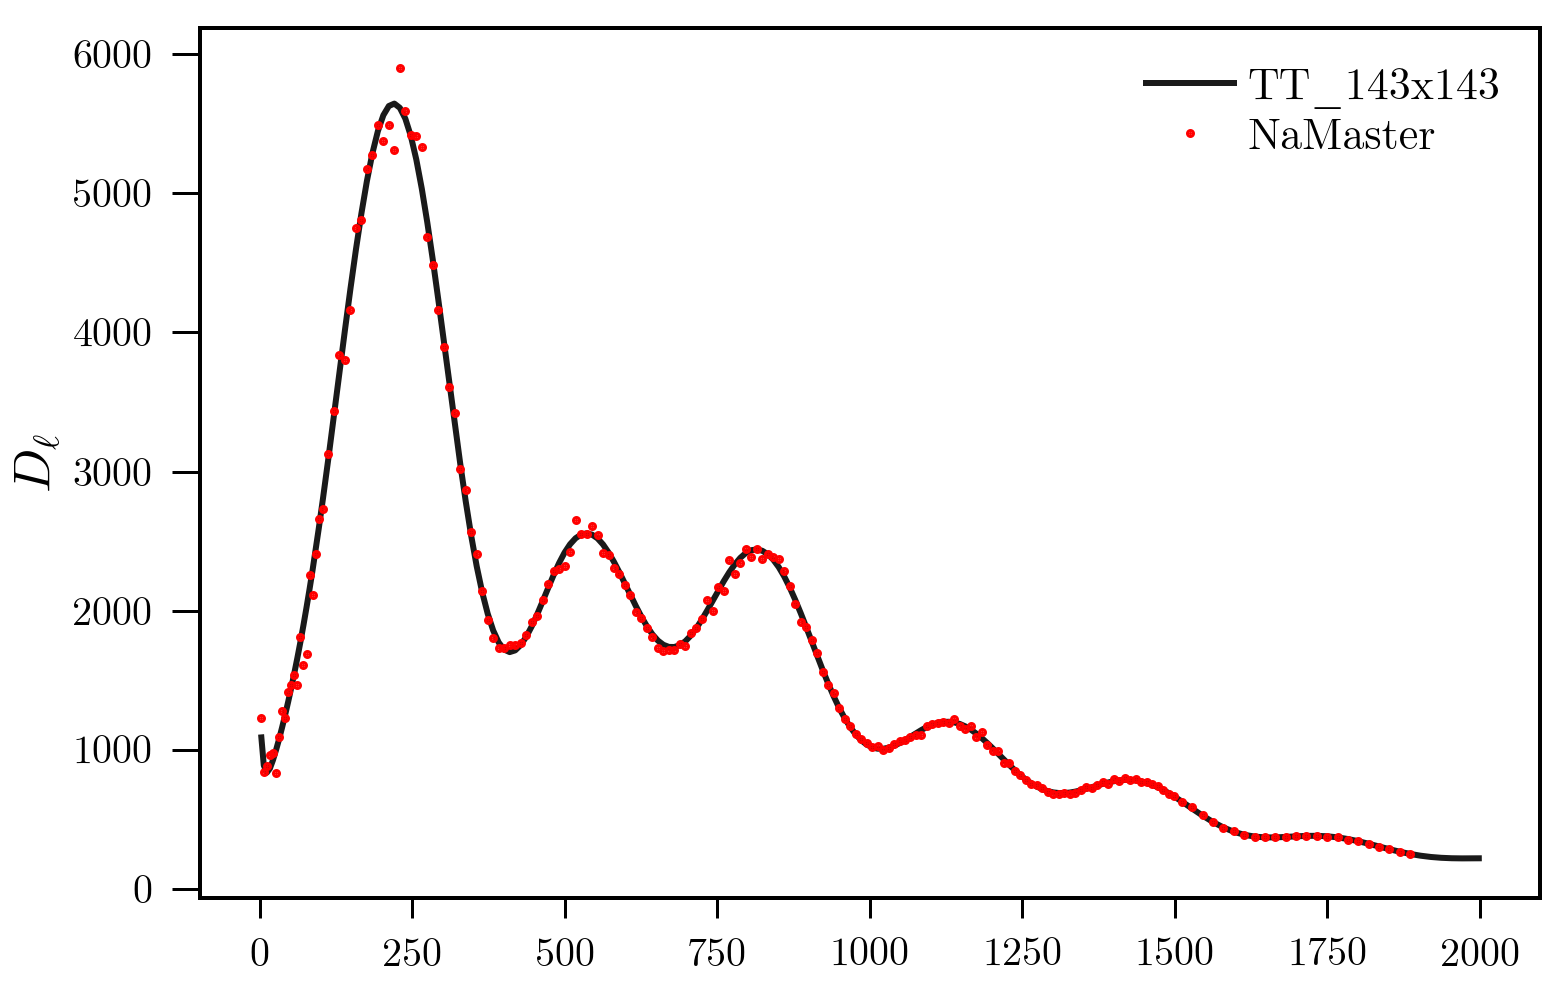

In [123]:
plt.figure(figsize=(12,8))
dlfac = ell*(ell+1) / 2 / np.pi
plt.plot(binned_ell,binned_theory,label='%s'%'TT_143x143')
plt.plot(ell[:199], (cl* 1e12* dlfac)[:199],'r.',label=r"NaMaster")

plt.legend()
plt.ylabel(r"$D_{\ell}$")
# plt.yscale('log')

(-0.15, 0.15)

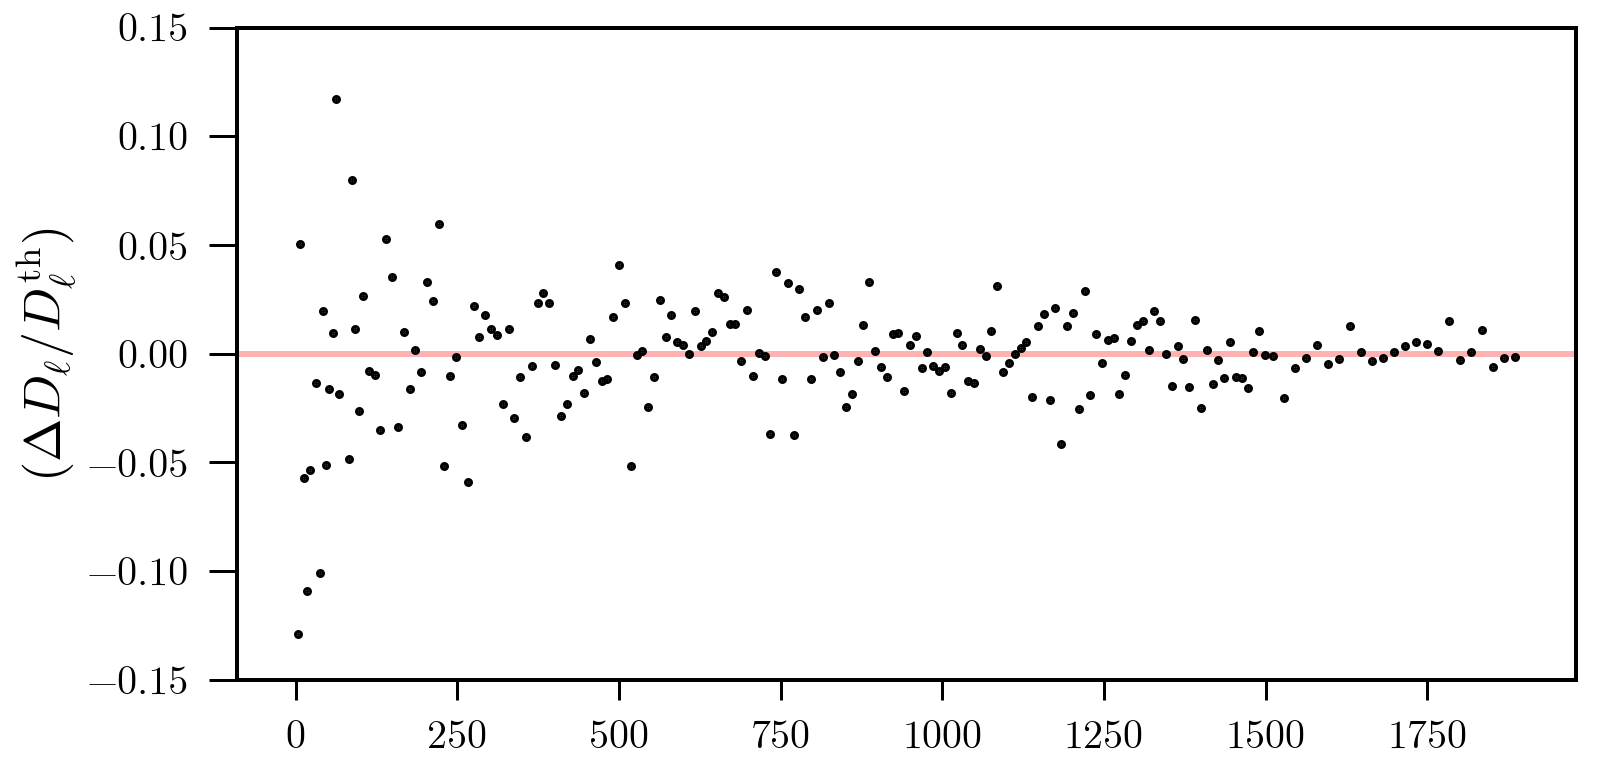

In [121]:
plt.figure(figsize=(12,6))
plt.axhline(.0, color='red', alpha=0.3)
plt.plot( ell[:199], ((binned_theory-cl*1e12* dlfac) / binned_theory)[:199], 'k.')
plt.ylabel(r'$(\Delta D_{\ell} / D_{\ell}^{\mathrm{th}})$')
plt.ylim(-0.15, 0.15)